In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from data_loading import load_data, create_sequences, normalize_velocity, filter_and_assign_features, calculate_velocities,create_dataloader 
from model_definitions import CNNGenerator1, CNNGenerator2, CNNDiscriminator1, CNNDiscriminator2, weights_init
from training import train_gan
import pandas as pd

In [2]:
# Define your paths and constants
FOLDER_PATH = '/home/shailendra/Documents/PhD_Oslomet/QuantumGanWaldo/WALDO/WalDo'
SEQUENCE_LENGTH = 200
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load data
all_files_data = load_data(FOLDER_PATH)
dataset = all_files_data[0]
# Filter and assign features
feature_data = filter_and_assign_features(dataset)
xpl, ypl, xpr, ypr = feature_data['xpl'], feature_data['ypl'], feature_data['xpr'], feature_data['ypr']
# Calculate velocities
velocity_left, velocity_right = calculate_velocities(xpl, ypl, xpr, ypr)
# Prepare the velocity data for further processing
velocity_data = pd.DataFrame({
    'velocity_left': velocity_left
})
#velocity_data['velocity_left'].ffill(inplace=True)  # Handle NaNs
velocity_data['velocity_left'] = velocity_data['velocity_left'].ffill()  # Handle NaNs
# Normalize the velocity data
velocity_data = normalize_velocity(velocity_data)
# Create sequences from the normalized data
subset_velocity_data = velocity_data['normalized_velocity'][:4199]
sequences = create_sequences(subset_velocity_data, SEQUENCE_LENGTH)
# Prepare DataLoader
train_loader = create_dataloader(sequences, BATCH_SIZE)

In [3]:
# For Model 1
generator1 = CNNGenerator1(input_channels=256, output_channels=1).to(DEVICE)
discriminator1 = CNNDiscriminator1().to(DEVICE)
# For Model 2
generator2 = CNNGenerator2(input_channels=256, output_channels=1).to(DEVICE)
discriminator2 = CNNDiscriminator2().to(DEVICE)
# Initialize weights for both models
generator1.apply(weights_init)
discriminator1.apply(weights_init)
generator2.apply(weights_init)
discriminator2.apply(weights_init)
# Set hyperparameters
lr = 0.0002
input_channels = 256
nb_epoch = 4

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--



Epoch [1/4] G: 14.74395190179348, Dr: 0.4583589122630656, Df: 0.35198730835691094, JS: inf


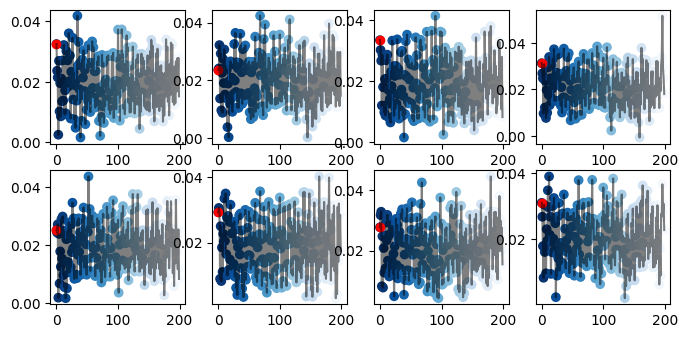

 25% (1 of 4) |######                    | Elapsed Time: 0:00:01 ETA:   0:00:04



Epoch [2/4] G: 4.780136905610561, Dr: 0.09997336089145392, Df: 0.11546681926120073, JS: inf


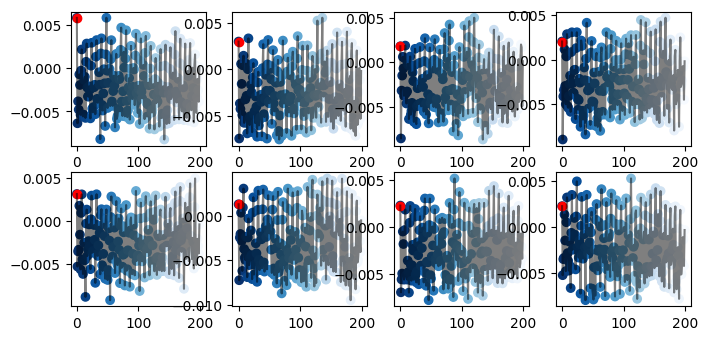

 50% (2 of 4) |#############             | Elapsed Time: 0:00:03 ETA:   0:00:03



Epoch [3/4] G: 1.6575584392994642, Dr: 0.06694299168884754, Df: 0.08553043362917379, JS: 0.004444722129846923


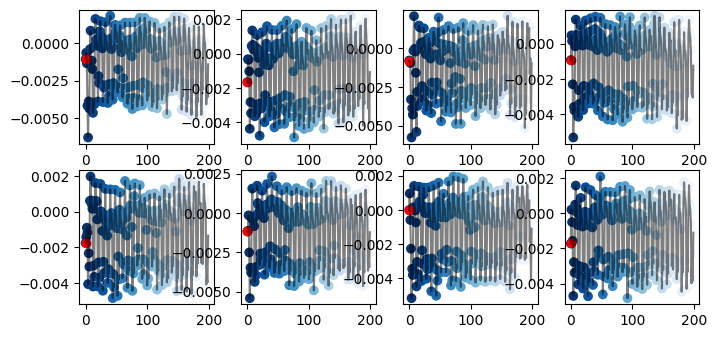

 75% (3 of 4) |###################       | Elapsed Time: 0:00:04 ETA:   0:00:01



Epoch [4/4] G: 1.076294792816043, Dr: 0.032416159025160596, Df: 0.030518494051648304, JS: 0.0053421632837853394


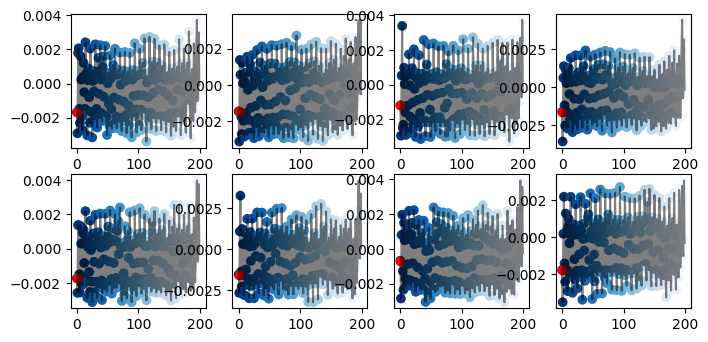

100% (4 of 4) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06


In [4]:
# Define periodogram function
def periodogram(tt):
    return torch.log(torch.mean(torch.fft.fft(tt, 200).abs(), 0))
# Train Model 1
train_gan(generator1, discriminator1, train_loader, input_channels, nb_epoch, lr, DEVICE, periodogram, 'model_1')

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--



Epoch [1/4] G: 3.3934078188613057, Dr: 0.3780519384890795, Df: 0.38112242240458727, JS: 0.00352246868351358


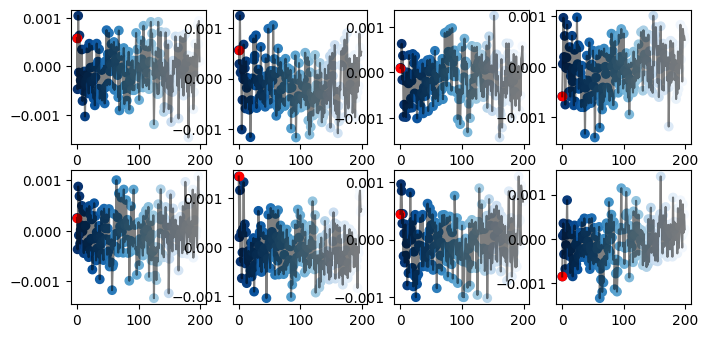

 25% (1 of 4) |######                    | Elapsed Time: 0:00:02 ETA:   0:00:06



Epoch [2/4] G: 0.2942765858024359, Dr: 0.13777794386260211, Df: 0.12351395632140338, JS: 0.0013184601557441056


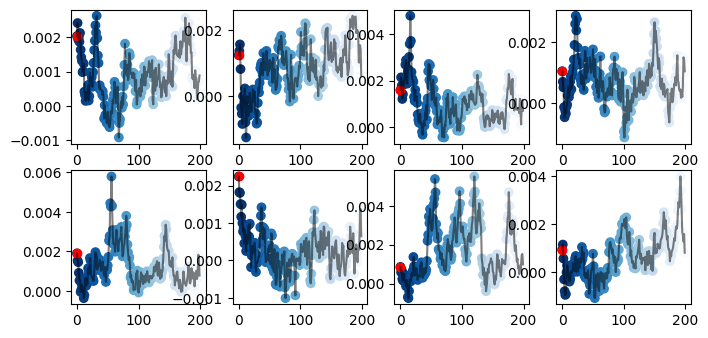

 50% (2 of 4) |#############             | Elapsed Time: 0:00:04 ETA:   0:00:04



Epoch [3/4] G: 0.21100698760710657, Dr: 0.25515944592189044, Df: 0.25986439554253593, JS: 0.0004891345306532457


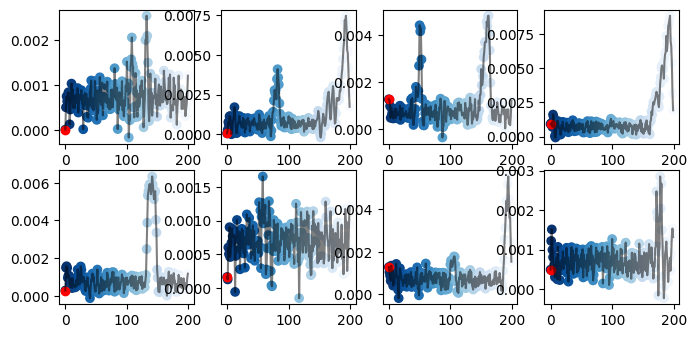

 75% (3 of 4) |###################       | Elapsed Time: 0:00:06 ETA:   0:00:02



Epoch [4/4] G: 0.10808725527022034, Dr: 0.46216913126409054, Df: 0.46127690793946385, JS: 0.00040764204641163815


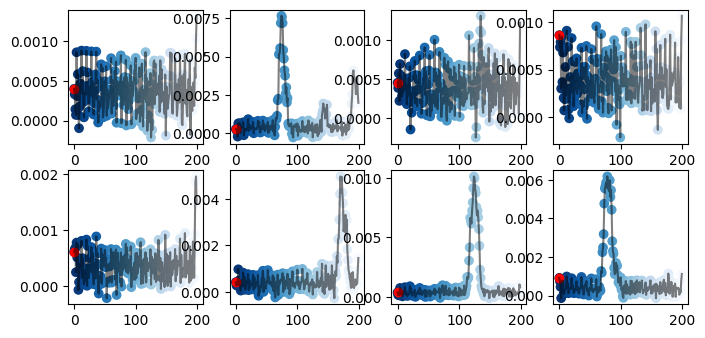

100% (4 of 4) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08


In [5]:
# Train Model 2
train_gan(generator2, discriminator2, train_loader, input_channels, nb_epoch, lr, DEVICE, periodogram, 'model_2')


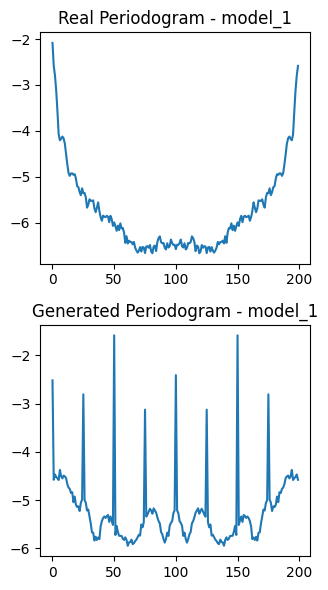

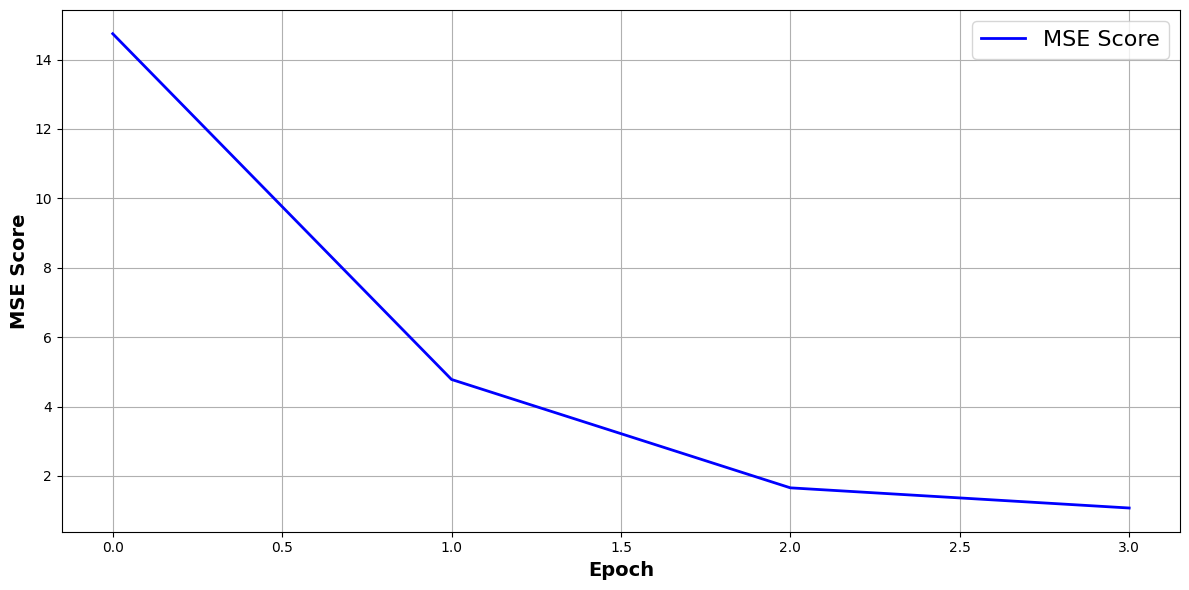

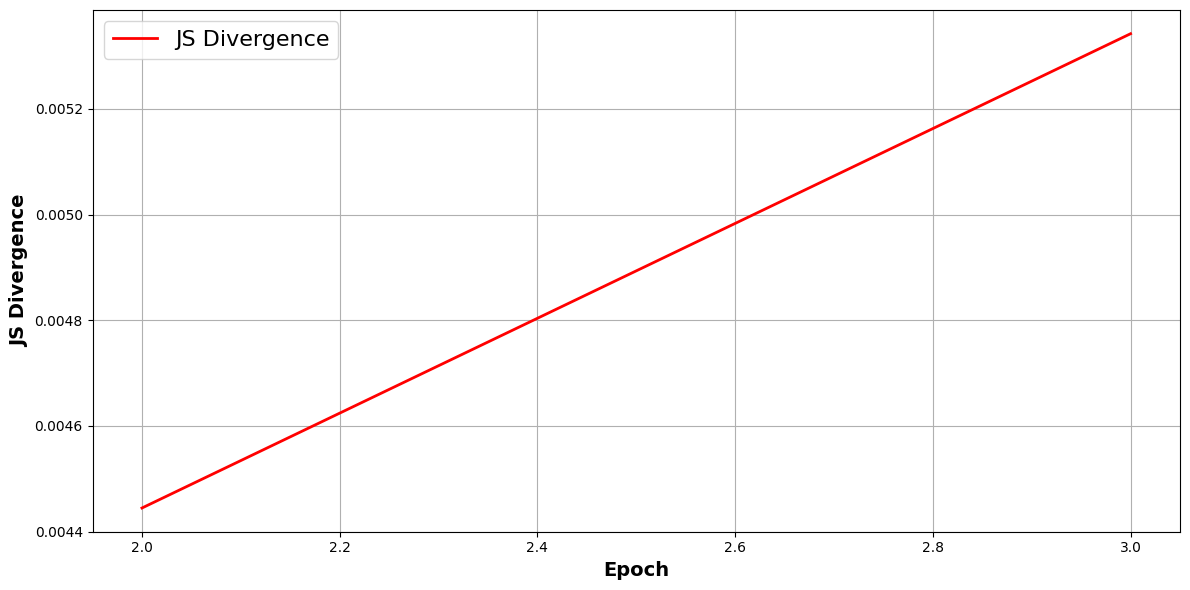

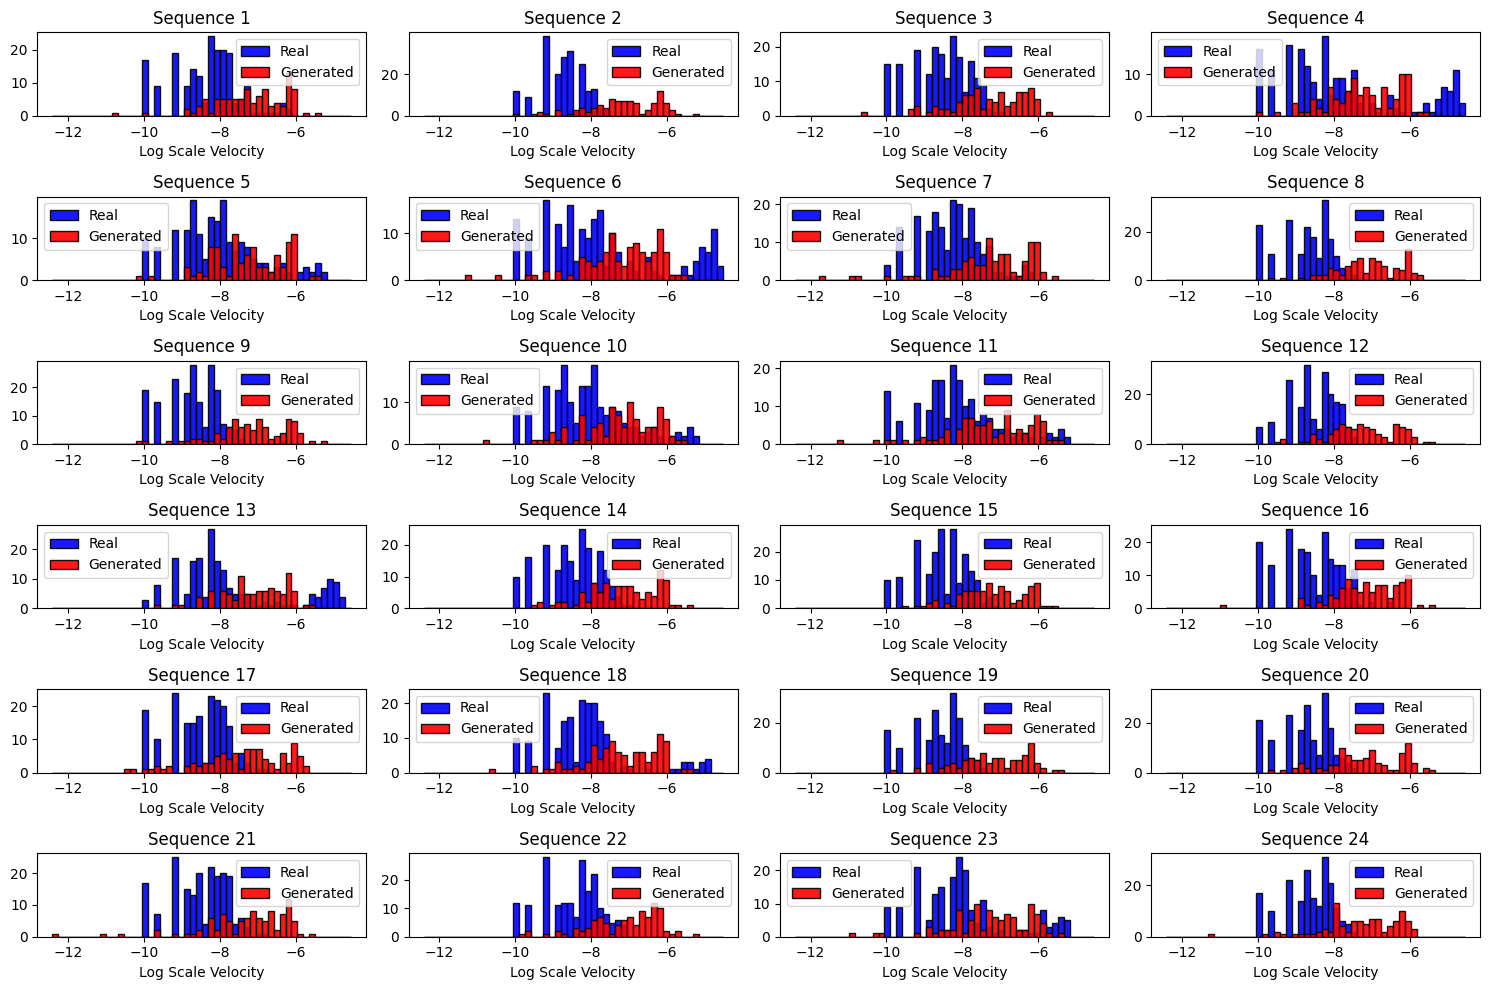

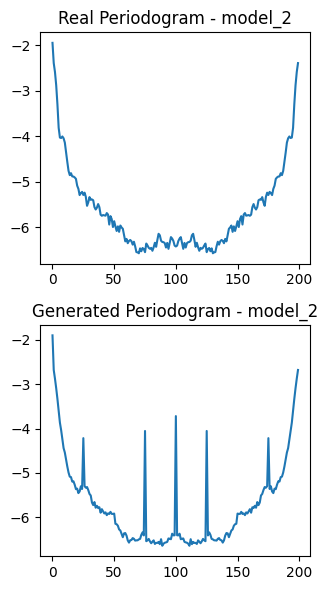

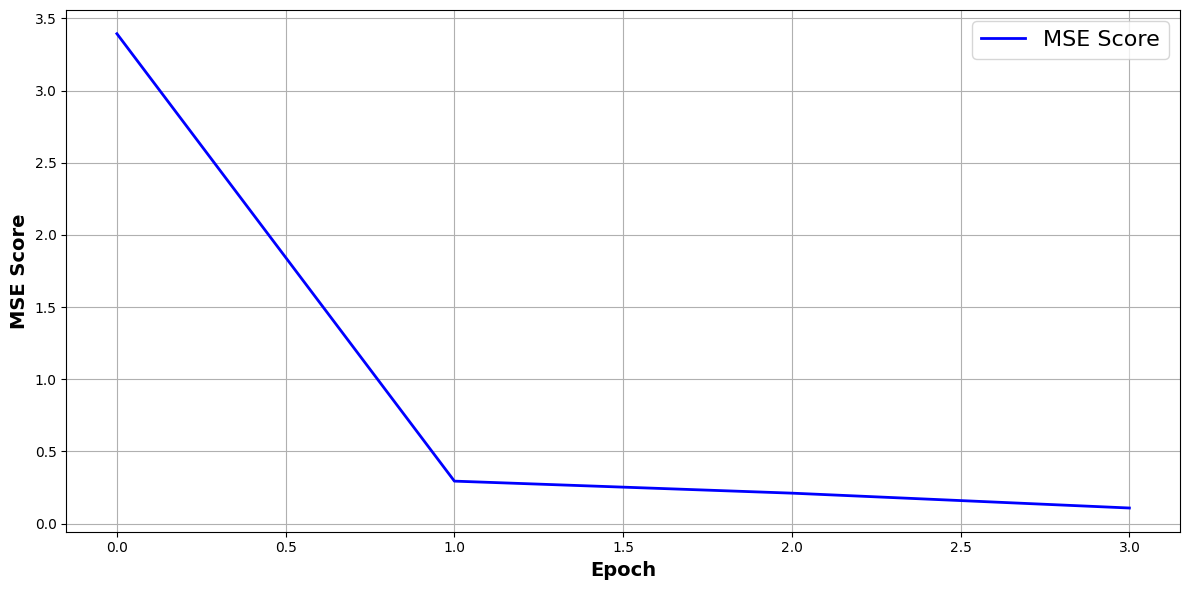

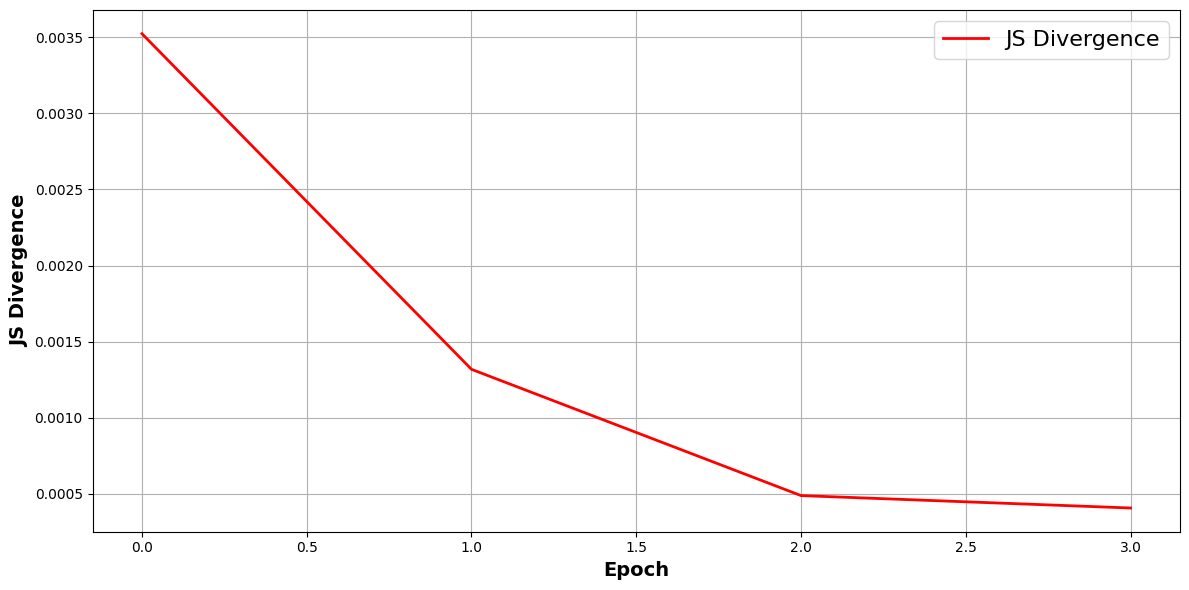

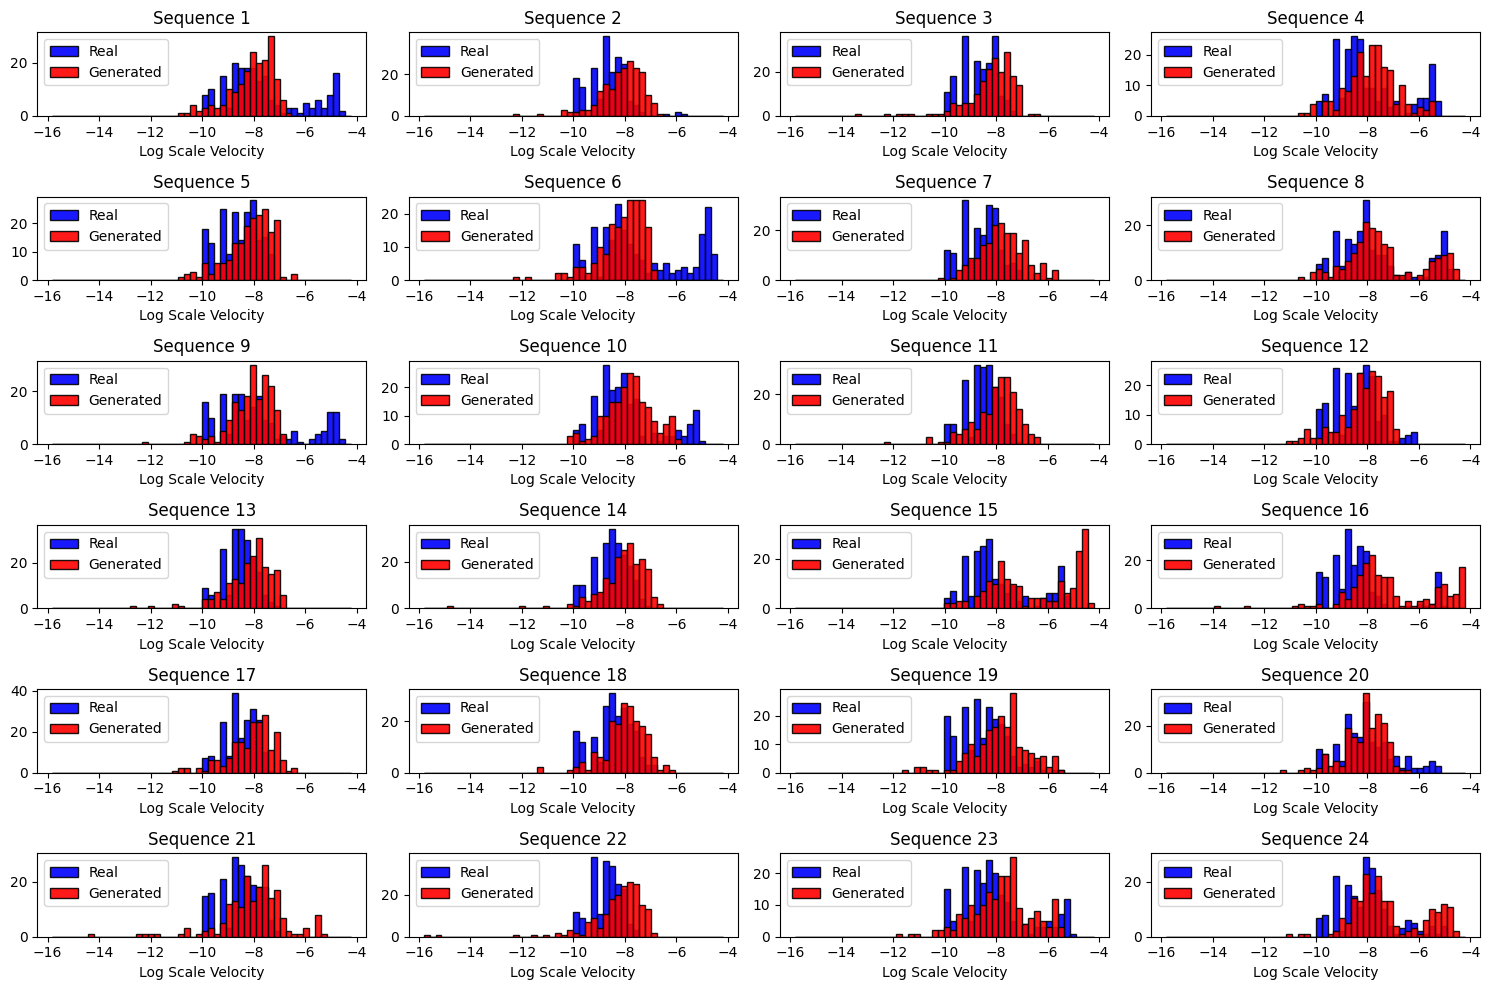

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to visualize results for a model
def visualize_results(generator, train_loader, model_name, input_channels, device):
    # Visualize real and generated periodograms
    real_sample = next(iter(train_loader)).to(device)
    z = torch.randn((real_sample.size(0), input_channels, 1), device=device)
    with torch.no_grad():
        generated_sample = generator(z)
    real_periodogram = periodogram(real_sample)
    generated_periodogram = periodogram(generated_sample)
    # Convert to CPU and detach for plotting
    real_periodogram = real_periodogram.cpu().detach().numpy()
    generated_periodogram = generated_periodogram.cpu().detach().numpy()
    # Ensure the periodogram arrays have enough samples
    num_samples = min(real_periodogram.shape[0], generated_periodogram.shape[0], 4)  # Plot up to 4 samples

    # Plotting
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):  # Plotting up to 4 samples
        plt.subplot(2, 4, i + 1)
        plt.plot(real_periodogram[i].flatten(), label='Real')
        plt.title(f'Real Periodogram - {model_name}')
        plt.subplot(2, 4, i + 5)
        plt.plot(generated_periodogram[i].flatten(), label='Generated')
        plt.title(f'Generated Periodogram - {model_name}')

    plt.tight_layout()
    plt.show()

    # Load the saved scores
    js_scores = np.load(f'./results/{model_name}_js_scores.npy')
    mse_scores = np.load(f'./results/{model_name}_mse_scores.npy')

    # Plot and save MSE scores
    plt.figure(figsize=(12, 6))
    plt.plot(mse_scores, label='MSE Score', linewidth=2, color='blue')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('MSE Score', fontsize=14, fontweight='bold')
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./results/{model_name}_mse_scores.pdf')
    plt.show()

    # Plot and save JS scores
    plt.figure(figsize=(12, 6))
    plt.plot(js_scores, label='JS Divergence', linewidth=2, color='red')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('JS Divergence', fontsize=14, fontweight='bold')
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./results/{model_name}_js_scores.pdf')
    plt.show()

    # Fetch a batch of real data from the DataLoader
    real_data = next(iter(train_loader))
    real_data = real_data[:24]  # Select 24 samples for comparison
    # Generate a batch of data using the generator model
    num_samples = 24
    latent_dim = input_channels  # Ensure this matches your latent dimension
    z = torch.randn((num_samples, latent_dim, 1), device=device)
    with torch.no_grad():
        generated_data = generator(z)
    generated_data = generated_data.cpu().detach()[:24]  # Select 24 samples for comparison
    # Flatten the data to determine combined range for min-max binning
    all_data = np.concatenate([real_data.cpu().numpy().flatten(), generated_data.numpy().flatten()])
    # Filter velocities greater than zero
    positive_all_data = all_data[all_data > 0]
    # Compute the log of positive data
    log_all_data = np.log(positive_all_data)
    # Determine bin edges based on the combined range of values
    num_bins = 50
    bin_edges = np.linspace(log_all_data.min(), log_all_data.max(), num_bins + 1)
    # Plotting histograms
    plt.figure(figsize=(15, 10))
    num_plots = 24  # Number of plots to show

    # Plot real and generated data histograms
    for i in range(num_plots):
        plt.subplot(6, 4, i + 1)
        generated_sample = generated_data[i].squeeze().numpy()
        real_sample = real_data[i].squeeze().numpy()

        # Filter out non-positive values
        generated_sample = generated_sample[generated_sample > 0]
        real_sample = real_sample[real_sample > 0]

        # Compute the log of positive data
        log_generated_sample = np.log(generated_sample)
        log_real_sample = np.log(real_sample)
        
        plt.hist(log_real_sample, bins=bin_edges, alpha=0.9, label='Real', color='blue', edgecolor='black')
        plt.hist(log_generated_sample, bins=bin_edges, alpha=0.9, label='Generated', color='red', edgecolor='black')
        plt.title(f'Sequence {i+1}')
        plt.xlabel('Log Scale Velocity')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f'./results/{model_name}_histograms.pdf')
    plt.show()

# Call the function for Model 1 and 2
visualize_results(generator1, train_loader, 'model_1', input_channels, DEVICE)
visualize_results(generator2, train_loader, 'model_2', input_channels, DEVICE)

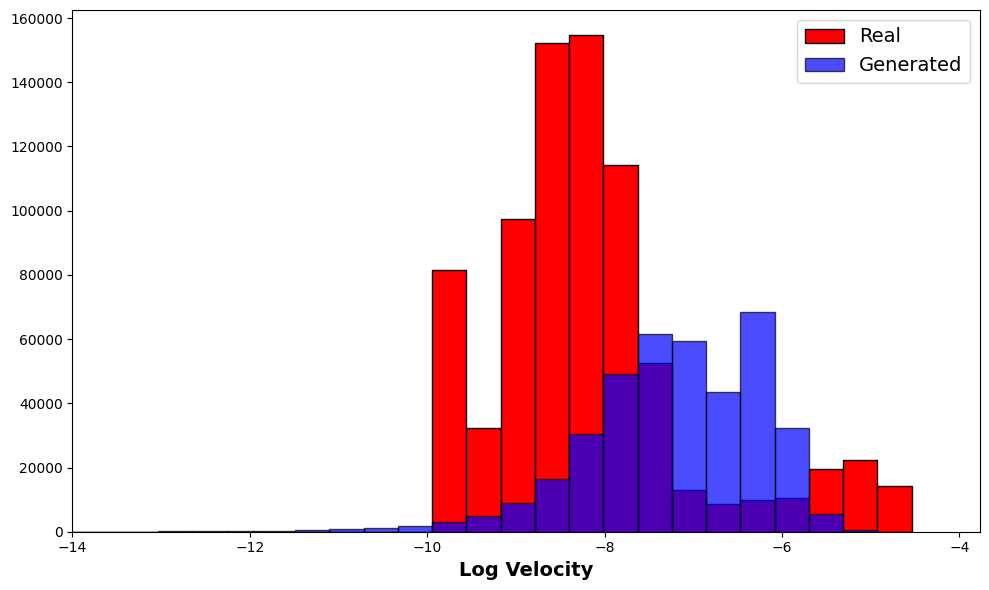

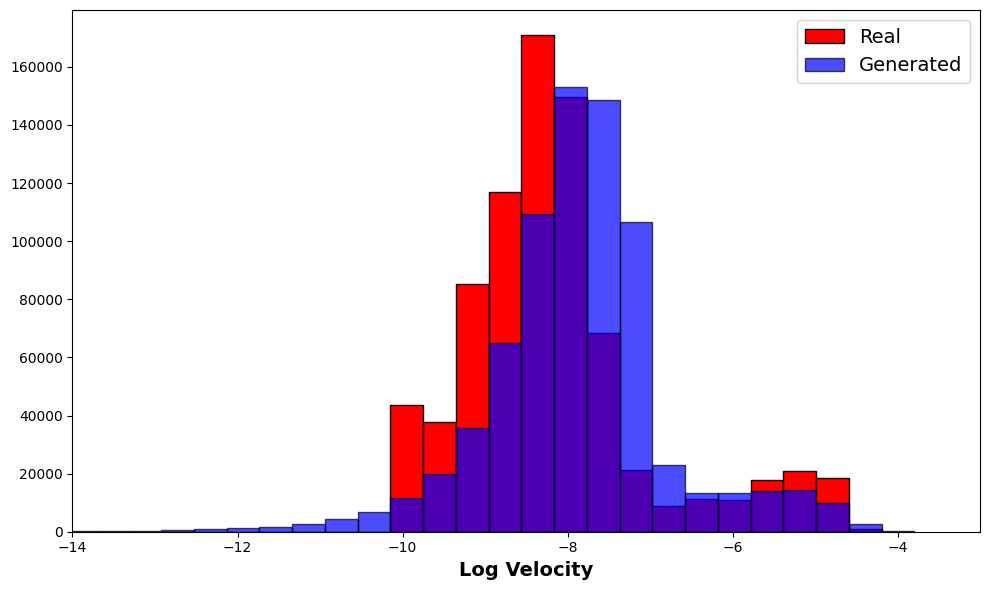

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to generate and compare histograms of real vs generated data
def plot_real_vs_generated_hist(generator, train_loader, latent_dim, model_name, device):
    # Fetch all real data from the DataLoader
    all_real_data = []
    for batch in train_loader:
        all_real_data.append(batch)
    all_real_data = torch.cat(all_real_data)

    # Generate a batch of data using the generator model
    num_samples = len(all_real_data)
    z = torch.randn((num_samples, latent_dim, 1), device=device)
    with torch.no_grad():
        all_generated_data = generator(z)
    all_generated_data = all_generated_data.cpu().detach()

    # Flatten the real and generated data
    flattened_real_data = all_real_data.numpy().flatten()
    flattened_generated_data = all_generated_data.numpy().flatten()

    # Filter velocities greater than zero
    positive_real_data = flattened_real_data[flattened_real_data > 0]
    positive_generated_data = flattened_generated_data[flattened_generated_data > 0]

    # Compute the log of positive data
    log_positive_real_data = np.log(positive_real_data)
    log_positive_generated_data = np.log(positive_generated_data)

    # Determine the range for the bins based on the combined data
    min_value = min(log_positive_real_data.min(), log_positive_generated_data.min())
    max_value = max(log_positive_real_data.max(), log_positive_generated_data.max())

    # Create bins
    num_bins = 40
    bins = np.linspace(min_value, max_value, num_bins + 1)

    # Plotting histograms
    plt.figure(figsize=(10, 6))
    plt.hist(log_positive_real_data, bins=bins, alpha=1, label='Real', color='red', edgecolor='black')
    plt.hist(log_positive_generated_data, bins=bins, alpha=0.7, label='Generated', color='blue', edgecolor='black')
    plt.xlabel('Log Velocity', fontsize=14, fontweight='bold')
    plt.legend(fontsize=14)

    # Fit the plot in the most zoomed form
    plt.xlim(left=-14)
    plt.tight_layout()

    # Save the plot as PDF
    plt.savefig(f'./results/RealVSGenerated_{model_name}_velDCGAN.pdf')
    plt.show()

# Call the function for Model 1
plot_real_vs_generated_hist(generator1, train_loader, latent_dim=256, model_name='model_1', device=DEVICE)

# Call the function for Model 2
plot_real_vs_generated_hist(generator2, train_loader, latent_dim=256, model_name='model_2', device=DEVICE)


In [16]:
from hiddenMarkov import train_hmm_2_hidden_states, train_hmm_3_hidden_states

# Train and use the HMM with 2 hidden states
HMmodel_2HS, HMgenerated_data_2HS, log_HMgenerated_data_2HS, states_2HS = train_hmm_2_hidden_states(velocity_left)
print(f"Generated Data with 2 Hidden States:\n{HMgenerated_data_2HS}")

# Train and use the HMM with 3 hidden states
HMmodel_3HS, HMgenerated_data_3HS, log_HMgenerated_data_3HS, states_3HS = train_hmm_3_hidden_states(velocity_left)
print(f"Generated Data with 3 Hidden States:\n{HMgenerated_data_3HS}")


Generated Data with 2 Hidden States:
[0.02258925 0.0236793  0.01293131 ... 0.12529786 0.13393841 0.11640877]
Generated Data with 3 Hidden States:
[0.00738812 0.02832297 0.05863554 ... 0.31010298 0.70498129 0.2708916 ]


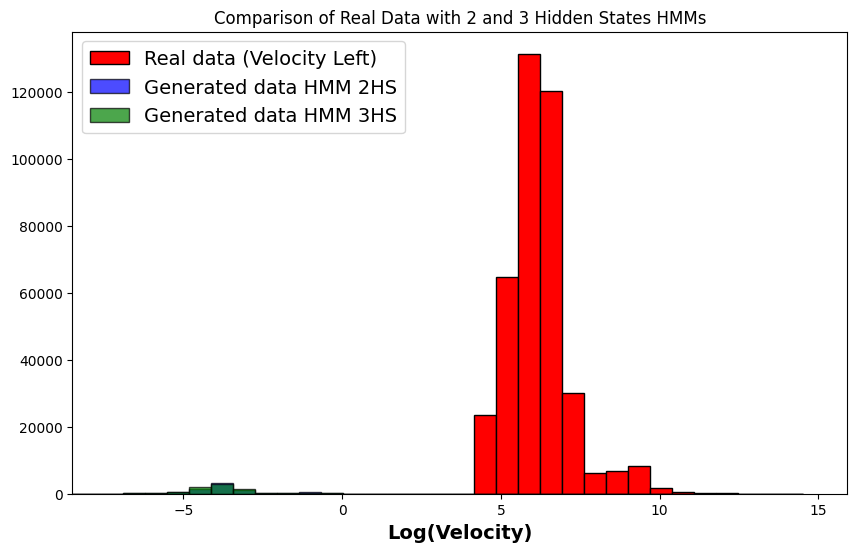

JS Divergence for 2 Hidden States HMM: 0.6931471805599454
JS Divergence for 3 Hidden States HMM: 0.6931471805599454


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

data = pd.DataFrame({
    'velocity_left': velocity_left  # Make sure this variable is defined and loaded
})
cleaned_data = data.dropna(subset=['velocity_left']).copy()

# Select only the first 4000 data points
if len(cleaned_data) >= 4000:
    cleaned_data = cleaned_data.iloc[:8000]
else:
    print("Not enough data points after removing NaNs.")
# Normalize the 'velocity_left' data
scaler = MinMaxScaler()
cleaned_data['velocity_left'] = scaler.fit_transform(cleaned_data[['velocity_left']])
# Verify no NaN values remain
if cleaned_data['velocity_left'].isna().any():
    print("NaN values detected, check data input or filling strategy.")
else:
    print("\nNormalized Data:")
    print(cleaned_data)
# Optionally, display the normalized data for the first few records
print(cleaned_data.head())
def js_divergence(P, Q):
    # Ensure the distributions are normalized
    P_norm = P / np.sum(P)
    Q_norm = Q / np.sum(Q)
    # Calculate the midpoint distribution
    M = 0.5 * (P_norm + Q_norm)
    return 0.5 * (entropy(P_norm, M) + entropy(Q_norm, M))

def plot_histogram_and_jsd(log_real_data, log_generated_data, num_bins, label_real, label_generated, title):
    # Calculate the minimum and maximum values for binning
    min_value = min(np.min(log_real_data), np.min(log_generated_data))
    max_value = max(np.max(log_real_data), np.max(log_generated_data))

    # Create bin edges using min-max binning
    bin_edges = np.linspace(min_value, max_value, num_bins + 1)

    # Plotting the histogram of the log-transformed positive velocities
    plt.figure(figsize=(10, 6))
    plt.hist(log_real_data, bins=bin_edges, alpha=1, label=label_real, color='red', edgecolor='black')
    plt.hist(log_generated_data, bins=bin_edges, alpha=0.7, label=label_generated, color='blue', edgecolor='black')
    plt.xlabel('Log(Velocity)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=14)
    plt.xlim(left=-8.5)
    plt.title(title)

    plt.show()

    # Calculate histograms with the same bin edges for JS divergence calculation
    hist_real, _ = np.histogram(log_real_data, bins=bin_edges, density=True)
    hist_generated, _ = np.histogram(log_generated_data, bins=bin_edges, density=True)

    # Calculate the JS Divergence
    jsd_value = js_divergence(hist_real, hist_generated)
    print(f"JS Divergence {label_generated}: {jsd_value}")

# Assuming log_real_data is calculated based on real velocity_left data
real_data = cleaned_data[cleaned_data['velocity_left'] > 0]
log_real_data = np.log(real_data['velocity_left'])

# Number of bins for histogram
num_bins = 40

# Plot and calculate JS Divergence for HMM with 2 Hidden States
plot_histogram_and_jsd(log_real_data, log_HMgenerated_data_2HS, num_bins,
                       label_real="Real data", label_generated="Generated data HMM 2HS", title="2 Hidden States")

# Plot and calculate JS Divergence for HMM with 3 Hidden States
plot_histogram_and_jsd(log_real_data, log_HMgenerated_data_3HS, num_bins,
                       label_real="Real data", label_generated="Generated data HMM 3HS", title="3 Hidden States")
